Reading Task Schedule

In [ ]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry
from datetime import timedelta

tasks_df = pd.read_csv('data/tasks_2025.csv', parse_dates=['start_date', 'end_date'])

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 52.52,
    "longitude": 13.41,
    "daily": [
        "sunset", "sunrise", "wind_speed_10m_max", "wind_gusts_10m_max", "uv_index_max", "weather_code",
        "temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min",
        "daylight_duration", "sunshine_duration", "uv_index_clear_sky_max", "rain_sum", "showers_sum",
        "snowfall_sum", "precipitation_sum", "precipitation_hours", "precipitation_probability_max",
        "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"
    ],
    # "timezone": "Europe/London",
    "forecast_days": 16,
    # "start_date": "2025-08-16",
	# "end_date": "2025-08-22"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location
response = responses[0]

daily = response.Daily()
daily_data = {
    "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    ),
    "sunset": daily.Variables(0).ValuesInt64AsNumpy(),
    "sunrise": daily.Variables(1).ValuesInt64AsNumpy(),
    "wind_speed_10m_max": daily.Variables(2).ValuesAsNumpy(),
    "wind_gusts_10m_max": daily.Variables(3).ValuesAsNumpy(),
    "uv_index_max": daily.Variables(4).ValuesAsNumpy(),
    "weather_code": daily.Variables(5).ValuesAsNumpy(),
    "temperature_2m_max": daily.Variables(6).ValuesAsNumpy(),
    "temperature_2m_min": daily.Variables(7).ValuesAsNumpy(),
    "apparent_temperature_max": daily.Variables(8).ValuesAsNumpy(),
    "apparent_temperature_min": daily.Variables(9).ValuesAsNumpy(),
    "daylight_duration": daily.Variables(10).ValuesAsNumpy(),
    "sunshine_duration": daily.Variables(11).ValuesAsNumpy(),
    "uv_index_clear_sky_max": daily.Variables(12).ValuesAsNumpy(),
    "rain_sum": daily.Variables(13).ValuesAsNumpy(),
    "showers_sum": daily.Variables(14).ValuesAsNumpy(),
    "snowfall_sum": daily.Variables(15).ValuesAsNumpy(),
    "precipitation_sum": daily.Variables(16).ValuesAsNumpy(),
    "precipitation_hours": daily.Variables(17).ValuesAsNumpy(),
    "precipitation_probability_max": daily.Variables(18).ValuesAsNumpy(),
    "wind_direction_10m_dominant": daily.Variables(19).ValuesAsNumpy(),
    "shortwave_radiation_sum": daily.Variables(20).ValuesAsNumpy(),
    "et0_fao_evapotranspiration": daily.Variables(21).ValuesAsNumpy()
}
daily_dataframe = pd.DataFrame(data=daily_data)
daily_dataframe['time'] = pd.to_datetime(daily_dataframe['date'])

# Save or append API response to CSV
weather_csv_path = 'data/weather_api_response.csv'
try:
    existing_weather = pd.read_csv(weather_csv_path, parse_dates=['date'])
    combined_weather = pd.concat([existing_weather, daily_dataframe], ignore_index=True)
    combined_weather = combined_weather.drop_duplicates(subset=['date'])
    combined_weather.to_csv(weather_csv_path, index=False)
except FileNotFoundError:
    daily_dataframe.to_csv(weather_csv_path, index=False)

# Load weather data from CSV after ensuring it's saved updated one.
daily_dataframe = pd.read_csv(weather_csv_path, parse_dates=['date'])


#
#
#
# Staring Predicting weather delays and updating project schedule
def predict_weather_delays_live(tasks_df, weather_info_df):
    tasks_df['weather_delay_days'] = 0
    for index, task in tasks_df.iterrows():
        if task['weather_sensitive'] == 1:
            task_weather = weather_info_df[
                (weather_info_df['date'] >= task['start_date']) &
                (weather_info_df['date'] <= task['end_date'])
            ]
            # print(weather_info_df)
            # print(task_weather['precipitation_sum'])
            
            delay_days = ((task_weather['precipitation_sum'] >= 0.0).sum())
            # print(f"Task {task['task_name']} has {delay_days} delay days due to weather.")
            tasks_df.at[index, 'weather_delay_days'] = delay_days
    tasks_df['new_duration'] = tasks_df['duration_days'] + tasks_df['weather_delay_days']
    return tasks_df

# def recalculate_schedule(tasks_df):
#     tasks_df['new_start_date'] = pd.NaT
#     tasks_df['new_end_date'] = pd.NaT
#     for index, task in tasks_df.iterrows():
#         if pd.isna(task['depends_on']):
#             tasks_df.at[index, 'new_start_date'] = task['start_date']
#         else:
#             predecessor_end = tasks_df[tasks_df['task_id'] == task['depends_on']]['new_end_date'].iloc[0]
#             tasks_df.at[index, 'new_start_date'] = predecessor_end + timedelta(days=1)
#         tasks_df.at[index, 'new_end_date'] = tasks_df.at[index, 'new_start_date'] + timedelta(days=task['new_duration'] - 1)
#     return tasks_df

def recalculate_schedule(tasks_df):
    # Ensure dates are in datetime
    
    tasks_df['start_date'] = pd.to_datetime(tasks_df['start_date'])
    tasks_df['end_date'] = pd.to_datetime(tasks_df['end_date'])

    # Add recalculated dates columns
    tasks_df['new_start_date'] = pd.to_datetime(tasks_df['start_date'])
    tasks_df['new_end_date'] = pd.to_datetime(tasks_df['end_date'])

    # today_date = pd.Timestamp.now().normalize() # For Live date
    today_date = pd.Timestamp('2025-07-01')  # For testing with fixed date
    for i, task in tasks_df.iterrows():
        if task['start_date'] >= today_date:

            if pd.isna(task['depends_on']) or task['depends_on'] == "":
                # First task keeps original start
                new_start = task['start_date']
                print(new_start,'-------Independednt Task Start Date')

            else:
                # Get predecessor's recalculated end date
                predecessor_end = tasks_df.loc[tasks_df['task_id'] == task['depends_on'], 'new_end_date'].iloc[0]
                new_start = predecessor_end + timedelta(days=1)
                print(new_start,'-------Dependednt Task Start Date')
            
            new_end = task['end_date']
            if task['weather_sensitive'] == 1:
                # Calculate new end date based on duration_days
                new_end = new_start + timedelta(days=task['new_duration'] - 1)
                
                
                # Ensure dependent task starts after the end_date of the task it depends on
                # Only check if there is a dependency
                if not (pd.isna(task['depends_on']) or task['depends_on'] == ""):
                    predecessor_end = tasks_df.loc[tasks_df['task_id'] == task['depends_on'], 'new_end_date'].iloc[0]
                    if new_start <= predecessor_end:
                        new_start = predecessor_end + timedelta(days=1)
                        if task['weather_sensitive'] == 1:
                            new_end = new_start + timedelta(days=task['new_duration'] - 1)
                        else:
                            new_end = new_start + timedelta(days=task['duration_days'] - 1)
            # Save in dataframe
            tasks_df.at[i, 'new_start_date'] = new_start
            tasks_df.at[i, 'new_end_date'] = new_end

    return tasks_df


# Apply weather delays
# Ensure both columns are timezone-naive or both are timezone-aware before comparison
if daily_dataframe['date'].dt.tz is not None:
    daily_dataframe['date'] = daily_dataframe['date'].dt.tz_localize(None)
if tasks_df['start_date'].dt.tz is not None:
    tasks_df['start_date'] = tasks_df['start_date'].dt.tz_localize(None)
if tasks_df['end_date'].dt.tz is not None:
    tasks_df['end_date'] = tasks_df['end_date'].dt.tz_localize(None)

tasks_df = predict_weather_delays_live(tasks_df, daily_dataframe)
# print(tasks_df)
# Recalculate schedule
tasks_df = recalculate_schedule(tasks_df)
# print(tasks_df)
# Format dates for output
tasks_df['new_start_date'] = tasks_df['new_start_date'].dt.strftime('%Y-%m-%d')
tasks_df['new_end_date'] = tasks_df['new_end_date'].dt.strftime('%Y-%m-%d')

# Save updated tasks to CSV (append or overwrite as needed)
tasks_csv_path = 'data/tasks_2025_updated.csv'
tasks_df.to_csv(tasks_csv_path, index=False)

print("Updated Project Schedule with Weather Delays:")
# print(tasks_df[['task_name', 'duration_days', 'new_start_date', 'new_end_date', 'new_duration']])


2025-07-01 00:00:00 -------Today Date
2025-05-28 00:00:00 -------Dependednt Task Start Date
2025-08-01 00:00:00 -------Dependednt Task Start Date
2025-08-01 00:00:00 -------Independednt Task Start Date
2025-08-11 00:00:00 -------Independednt Task Start Date
2025-08-21 00:00:00 -------Dependednt Task Start Date
Updated Project Schedule with Weather Delays:


In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# -------------------------------
# Step 1: Load dataset
# -------------------------------
df = pd.read_csv("data/weather_history_2024_daily.csv")   # Replace with your actual file path
# print("Initial Data:\n", df.head())
# Convert 'time' column to string, then to float (UNIX timestamp)
df['time'] = pd.to_datetime(df['time']).astype(np.int64) / 1e9
df['date'] = pd.to_datetime(df['time']).astype(np.int64) / 1e9
# -------------------------------
# Step 2: Handle missing values
# -------------------------------
df.fillna(0, inplace=True)

# -------------------------------
# Step 3: Create Target Variable (Delay or No Delay)
# -------------------------------
# Example rules for delay (adapted to your column names)
df["delay"] = np.where(
    (df["rain_sum"] > 5) | 
    (df["snowfall_sum"] > 2) |
    (df["wind_gusts_10m_max"] > 40),
    1, 0
)

# -------------------------------
# Step 4: Feature Selection
# -------------------------------
# Drop time + target
X = df.drop(columns=["time", "delay"])
y = df["delay"]

# -------------------------------
# Step 5: Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# Step 6: Train Random Forest
# -------------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# -------------------------------
# Step 7: Predictions
# -------------------------------
y_pred = model.predict(X_test)

# -------------------------------
# Step 8: Evaluation
# -------------------------------
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------
# Step 9: Feature Importance
# -------------------------------
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)

# -------------------------------
# Step 10: Save Model
# -------------------------------
joblib.dump(model, "weather_delay_model.pkl")
print("\n✅ Model saved as weather_delay_model.pkl")



Model Accuracy: 0.9594594594594594

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        46
           1       0.96      0.93      0.95        28

    accuracy                           0.96        74
   macro avg       0.96      0.95      0.96        74
weighted avg       0.96      0.96      0.96        74


Feature Importance:
                           Feature  Importance
4              wind_gusts_10m_max    0.394142
3              wind_speed_10m_max    0.206132
17              precipitation_sum    0.086242
14                       rain_sum    0.079727
6                    weather_code    0.041194
18            precipitation_hours    0.032077
20    wind_direction_10m_dominant    0.028161
22     et0_fao_evapotranspiration    0.016998
12              sunshine_duration    0.013953
21        shortwave_radiation_sum    0.013426
9        apparent_temperature_max    0.012451
2                         sunrise    0

20:36:28 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing


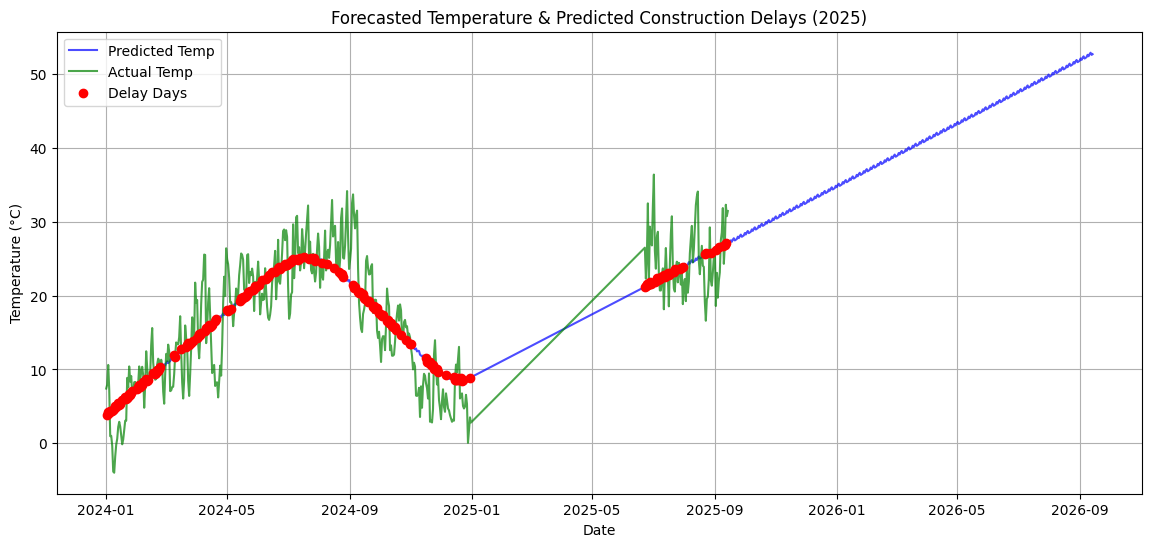

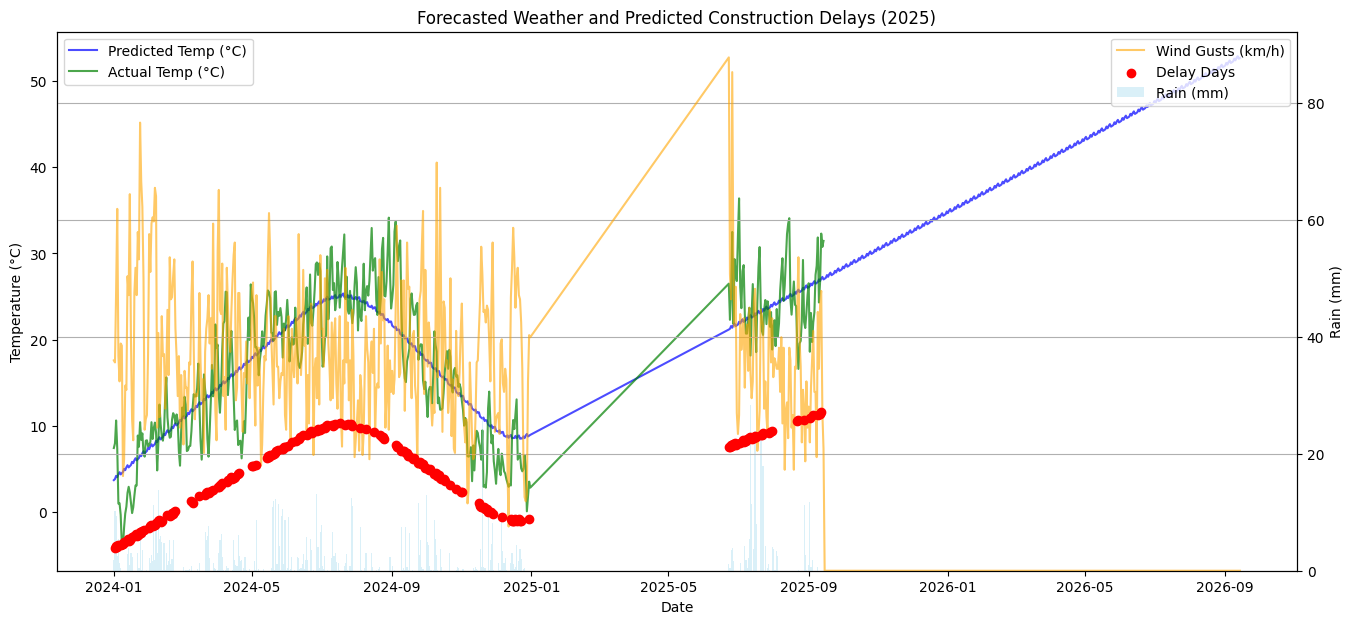

In [143]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Load datasets
df_2024 = pd.read_csv("data/weather_history_2024_daily.csv")
df_2025 = pd.read_csv("data/weather_api_response.csv")

# Convert to datetime (remove timezone info)
df_2024["time"] = pd.to_datetime(df_2024["time"]).dt.tz_localize(None)
df_2025["time"] = pd.to_datetime(df_2025["time"]).dt.tz_localize(None)

# -----------------------------
# 2. Combine both datasets
# -----------------------------
combined = pd.concat([df_2024, df_2025], ignore_index=True)

# -----------------------------
# 3. Prepare Prophet data (example: temperature_2m_max forecasting)
# -----------------------------
df_prophet = combined[["time", "temperature_2m_max"]].rename(
    columns={"time": "ds", "temperature_2m_max": "y"}
)

# Drop rows with missing values
df_prophet = df_prophet.dropna()

# -----------------------------
# 4. Train Prophet on 2024 + partial 2025
# -----------------------------
model = Prophet()
model.fit(df_prophet)

# Forecast until end of 2025
future = model.make_future_dataframe(periods=365, freq="D")  # predict daily
forecast = model.predict(future)

# -----------------------------
# 5. Merge predictions back
# -----------------------------
forecast = forecast[["ds", "yhat"]].rename(columns={"yhat": "predicted_temp"})
final = pd.merge(combined, forecast, left_on="time", right_on="ds", how="outer")

# -----------------------------
# 6. Add Delay Logic
# -----------------------------
def calculate_delay(row):
    # Example rule: delay if rain > 5mm OR wind > 40 km/h OR temp < 0°C
    rain = row.get("precipitation_sum", 0)
    wind = row.get("wind_gusts_10m_max", 0)
    temp = row.get("temperature_2m_max", row.get("predicted_temp", 0))

    if pd.isna(temp):  # handle NaN from forecast
        temp = 0

    if (rain and rain > 5) or (wind and wind > 40) or (temp < 0):
        return 1
    return 0

final["delay"] = final.apply(calculate_delay, axis=1)
# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(14, 6))

# Plot actual & forecasted temperatures
plt.plot(final["ds"], final["predicted_temp"], label="Predicted Temp", color="blue", alpha=0.7)
plt.plot(final["time"], final["temperature_2m_max"], label="Actual Temp", color="green", alpha=0.7)

# Highlight delay days
delay_days = final[final["delay"] == 1]
plt.scatter(delay_days["ds"], delay_days["predicted_temp"], color="red", label="Delay Days", zorder=5)

plt.title("Forecasted Temperature & Predicted Construction Delays (2025)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------------
# 7. Visualization: Temp, Rain, Wind, Delay
# -----------------------------
plt.figure(figsize=(16, 7))

# Temperature
plt.plot(final["ds"], final["predicted_temp"], label="Predicted Temp (°C)", color="blue", alpha=0.7)
plt.plot(final["time"], final["temperature_2m_max"], label="Actual Temp (°C)", color="green", alpha=0.7)

# Rain (secondary y-axis)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.bar(final["ds"], final["precipitation_sum"].fillna(0), width=1, alpha=0.3, color="skyblue", label="Rain (mm)")
ax2.set_ylabel("Rain (mm)")

# Wind (secondary y-axis)
ax2.plot(final["ds"], final["wind_gusts_10m_max"].fillna(0), color="orange", alpha=0.6, label="Wind Gusts (km/h)")

# Delay days
delay_days = final[final["delay"] == 1]
plt.scatter(delay_days["ds"], delay_days["predicted_temp"], color="red", label="Delay Days", zorder=5)

# Titles and legends
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°C)")
plt.title("Forecasted Weather and Predicted Construction Delays (2025)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()

In [145]:
import pandas as pd
from prophet import Prophet
import numpy as np

# -----------------------------
# 1. Load datasets
# -----------------------------
df_2024 = pd.read_csv("data/weather_history_2024_daily.csv")
df_2025_partial = pd.read_csv("data/weather_api_response.csv")

# Convert to datetime (remove timezone info)
df_2024["time"] = pd.to_datetime(df_2024["time"]).dt.tz_localize(None)
df_2025_partial["time"] = pd.to_datetime(df_2025_partial["time"]).dt.tz_localize(None)

# -----------------------------
# 2. Features to forecast
# -----------------------------
features = [
    "temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min",
    "precipitation_sum", "showers_sum", "snowfall_sum", "wind_speed_10m_max", "wind_gusts_10m_max"
]

# -----------------------------
# 3. Forecast each feature using Prophet
# -----------------------------
forecasted_features = []

for feature in features:
    # Prepare data
    df_prophet = df_2024[["time", feature]].rename(columns={"time": "ds", feature: "y"})
    df_prophet = df_prophet.dropna()
    
    # Train model
    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)
    
    # Forecast for 2025 (365 days)
    future = model.make_future_dataframe(periods=365, freq="D")
    forecast = model.predict(future)
    
    # Keep only forecasted values
    forecasted_features.append(forecast[["ds", "yhat"]].rename(columns={"yhat": feature}))

# -----------------------------
# 4. Merge all forecasts into one dataframe
# -----------------------------
df_forecast_2025 = forecasted_features[0]
for f in forecasted_features[1:]:
    df_forecast_2025 = pd.merge(df_forecast_2025, f, on="ds")

df_forecast_2025.rename(columns={"ds": "time"}, inplace=True)

# -----------------------------
# 5. Merge partial 2025 data if available
# -----------------------------
df_2025_full = pd.merge(df_forecast_2025, df_2025_partial, on="time", how="left", suffixes=("", "_actual"))

# -----------------------------
# 6. Add Delay Logic
# -----------------------------
def calculate_delay(row):
    rain = row.get("precipitation_sum_actual", row.get("precipitation_sum", 0)) or 0
    wind = row.get("wind_gusts_10m_max_actual", row.get("wind_gusts_10m_max", 0)) or 0
    temp = row.get("temperature_2m_max_actual", row.get("temperature_2m_max", 0)) or 0
    if (rain > 5) or (wind > 40) or (temp < 0):
        return 1
    return 0

df_2025_full["delay"] = df_2025_full.apply(calculate_delay, axis=1)

# -----------------------------
# 7. Save final 2025 forecast with delays
# -----------------------------
df_2025_full.to_csv("weather_2025_forecast_with_delays.csv", index=False)
print("2025 forecast with predicted delays saved successfully!")


20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:57 - cmdstanpy - INFO - Chain [1] start processing
20:39:57 - cmdstanpy - INFO - Chain [1] done processing
20:39:58 - cmdstanpy - INFO - Chain [1] start processing
20:39:58 - cmdstanpy - INFO - Chain [1] done processing
20:39:58 - cmdstanpy - INFO - Chain [1] start processing
20:39:58 - cmdstanpy - INFO - Chain [1] done processing
20:39:58 - cmdstanpy - INFO - Chain [1] start processing
20:39:58 - cmdstanpy - INFO - Chain [1] done processing


2025 forecast with predicted delays saved successfully!


In [147]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Generate dummy hourly weather data for January 2024
start_date = datetime(2024, 1, 1)
end_date = start_date + timedelta(days=31)
time_index = pd.date_range(start=start_date, end=end_date - timedelta(seconds=1), freq='H')
n_rows = len(time_index)

data = {
    'time': time_index,
    'temperature_2m (°C)': np.random.uniform(-5, 5, n_rows),
    'weather_code (wmo code)': np.random.randint(0, 100, n_rows),
    'rain (mm)': np.random.uniform(0, 5/12, n_rows),  # Adjusted for balance
    'snowfall (cm)': np.random.uniform(0, 1/12, n_rows),  # Adjusted for balance
    'precipitation (mm)': np.random.uniform(0, 5/12, n_rows),
    'apparent_temperature (°C)': np.random.uniform(-5, 5, n_rows),
    'relative_humidity_2m (%)': np.random.uniform(60, 100, n_rows),
    'precipitation_probability (%)': np.random.uniform(0, 100, n_rows),
    'showers (mm)': np.random.uniform(0, 3/12, n_rows),
    'snow_depth (m)': np.random.uniform(0, 0.09, n_rows),  # Adjusted to be < 0.1
    'pressure_msl (hPa)': np.random.uniform(990, 1010, n_rows),
    'surface_pressure (hPa)': np.random.uniform(990, 1010, n_rows),
    'visibility (m)': np.random.uniform(1000, 10000, n_rows),  # Adjusted to be > 1000
    'evapotranspiration (mm)': np.random.uniform(0, 2, n_rows),
    'et0_fao_evapotranspiration (mm)': np.random.uniform(0, 2, n_rows),
    'wind_speed_10m (km/h)': np.random.uniform(0, 40, n_rows),  # Adjusted to be < 50
    'wind_speed_80m (km/h)': np.random.uniform(0, 50, n_rows),
    'wind_speed_120m (km/h)': np.random.uniform(0, 60, n_rows),
    'wind_speed_180m (km/h)': np.random.uniform(0, 70, n_rows),
    'wind_gusts_10m (km/h)': np.random.uniform(0, 40, n_rows),
    'temperature_80m (°C)': np.random.uniform(-5, 5, n_rows),
    'temperature_120m (°C)': np.random.uniform(-5, 5, n_rows),
    'temperature_180m (°C)': np.random.uniform(-5, 5, n_rows),
    'soil_temperature_0cm (°C)': np.random.uniform(0, 5, n_rows),
    'soil_temperature_6cm (°C)': np.random.uniform(0, 5, n_rows),
    'soil_temperature_18cm (°C)': np.random.uniform(0, 5, n_rows),
    'soil_moisture_0_to_1cm (m³/m³)': np.random.uniform(0.2, 0.4, n_rows),
    'soil_moisture_1_to_3cm (m³/m³)': np.random.uniform(0.2, 0.4, n_rows),
    'soil_moisture_3_to_9cm (m³/m³)': np.random.uniform(0.2, 0.4, n_rows),
    'cloud_cover (%)': np.random.uniform(0, 100, n_rows),
    'soil_moisture_9_to_27cm (m³/m³)': np.random.uniform(0.2, 0.4, n_rows),
}

df = pd.DataFrame(data)
df.set_index('time', inplace=True)
# Step 2: Aggregate hourly data to daily data
aggregations = {
    'temperature_2m (°C)': 'mean',
    'weather_code (wmo code)': 'mean',
    'rain (mm)': 'sum',
    'snowfall (cm)': 'sum',
    'precipitation (mm)': 'sum',
    'apparent_temperature (°C)': 'mean',
    'relative_humidity_2m (%)': 'mean',
    'precipitation_probability (%)': 'mean',
    'showers (mm)': 'sum',
    'snow_depth (m)': 'max',
    'pressure_msl (hPa)': 'mean',
    'surface_pressure (hPa)': 'mean',
    'visibility (m)': 'min',
    'evapotranspiration (mm)': 'sum',
    'et0_fao_evapotranspiration (mm)': 'sum',
    'wind_speed_10m (km/h)': 'max',
    'wind_speed_80m (km/h)': 'max',
    'wind_speed_120m (km/h)': 'max',
    'wind_speed_180m (km/h)': 'max',
    'wind_gusts_10m (km/h)': 'max',
    'temperature_80m (°C)': 'mean',
    'temperature_120m (°C)': 'mean',
    'temperature_180m (°C)': 'mean',
    'soil_temperature_0cm (°C)': 'mean',
    'soil_temperature_6cm (°C)': 'mean',
    'soil_temperature_18cm (°C)': 'mean',
    'soil_moisture_0_to_1cm (m³/m³)': 'mean',
    'soil_moisture_1_to_3cm (m³/m³)': 'mean',
    'soil_moisture_3_to_9cm (m³/m³)': 'mean',
    'cloud_cover (%)': 'mean',
    'soil_moisture_9_to_27cm (m³/m³)': 'mean',
}

daily_df = df.resample('D').agg(aggregations)

# Step 3: Define the target variable 'suitable'
def is_suitable(row):
    if row['rain (mm)'] > 5 or \
       row['snowfall (cm)'] > 1 or \
       row['temperature_2m (°C)'] < 0 or row['temperature_2m (°C)'] > 35 or \
       row['wind_speed_10m (km/h)'] > 50 or \
       row['visibility (m)'] < 1000 or \
       row['snow_depth (m)'] > 0.1:
        return 0  # unsuitable
    else:
        return 1  # suitable

daily_df['suitable'] = daily_df.apply(is_suitable, axis=1)

# Step 4: Select features and target
features = [
    'temperature_2m (°C)',
    'rain (mm)',
    'snowfall (cm)',
    'precipitation (mm)',
    'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)',
    'visibility (m)',
    'snow_depth (m)',
]

X = daily_df[features]
y = daily_df['suitable']

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

print("Logistic Regression Coefficients:")
for feature, coef in zip(features, logreg.coef_[0]):
    print(f"{feature}: {coef}")

# Step 7: Train random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

print("Random Forest Feature Importances:")
for feature, importance in zip(features, rf.feature_importances_):
    print(f"{feature}: {importance}")

# Step 8: Identify days predicted as unsuitable
daily_df['predicted_suitable'] = rf.predict(X)
unsuitable_days = daily_df[daily_df['predicted_suitable'] == 0][['temperature_2m (°C)', 'rain (mm)', 'snowfall (cm)', 'wind_speed_10m (km/h)', 'visibility (m)', 'snow_depth (m)']]
print("\nDays Predicted as Unsuitable for Construction:")
print(unsuitable_days)

Logistic Regression Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7

Logistic Regression Coefficients:
temperature_2m (°C): 0.38255132970814804
rain (mm): -0.6424336712908099
snowfall (cm): 0.022252070705170636
precipitation (mm): 0.747388404827364
relative_humidity_2m (%): -0.1925835677503502
wind_speed_10m (km/h): 0.49468366257680474
visibility (m): -0.006195729595911781
snow_depth (m): 0.01019824398657775
Random Forest Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0

/tmp/ipykernel_17081/785634208.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_date, end=end_date - timedelta(seconds=1), freq='H')
/home/chandan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

KeyError: "None of [Index(['temperature_2m', 'rain', 'snowfall', 'precipitation_probability',\n       'relative_humidity_2m', 'wind_speed_10m', 'wind_gusts_10m',\n       'visibility', 'cloud_cover', 'soil_moisture_0_to_1cm', 'delayed'],\n      dtype='object')] are in the [columns]"